<a href="https://colab.research.google.com/github/vsolodkyi/NeuralNetworks_SkillBox/blob/main/module_5/conv_cats_finetune_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tuning в Keras

В этом уроке мы научимся применять transfer learning и fine-tuning для известной нам задачи классификации кошек и собак. И наконец, добьемся качества около 95%!

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#tf.enable_eager_execution()

BATCH_SIZE = 100
IMG_SHAPE  = 150 

_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)
base_dir = Path(zip_dir).parent / "cats_and_dogs_filtered"
train_dir = base_dir / 'train'
validation_dir = base_dir / 'validation'

train_cats_dir = train_dir / 'cats'
train_dogs_dir = train_dir / 'dogs'
validation_cats_dir = validation_dir / 'cats'
validation_dogs_dir = validation_dir / 'dogs'

68616192/68606236 [==============================] - 1s 0us/step


In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
image_gen_train = ImageDataGenerator(preprocessing_function=preprocess_input) # указываем preprocessing_function !!!

train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode='binary')

validation_image_generator = ImageDataGenerator(preprocessing_function=preprocess_input)  
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=validation_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                              class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
def show_catsdogs(images, labels, predicted_labels=None):
    names = {0: "Cat", 1: "Dog"}
    plt.figure(figsize=(10,10))
    for i in range(16):
        plt.subplot(4,4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow((images[i] + 1)/2., cmap=plt.cm.gray)
        if predicted_labels is not None:
            title_obj = plt.title(f"Real: {names[labels[i]]}. Pred: {names[predicted_labels[i]]}")
            if labels[i] != predicted_labels[i]:
                plt.setp(title_obj, color='r')
        else:
            plt.title(f"Real label: {names[labels[i]]}")

In [ ]:
IMG_SHAPE = (150, 150, 3)
# базовая модель -- MobileNet
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False # замораживаем всю базовую модель
base_model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 75, 75, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 75, 75, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReL

In [ ]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback

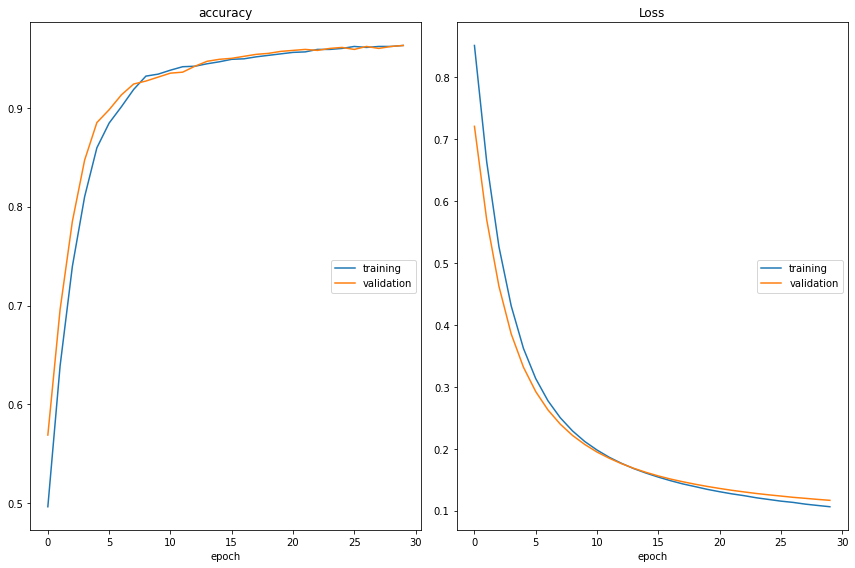

accuracy
	training         	 (min:    0.496, max:    0.963, cur:    0.963)
	validation       	 (min:    0.569, max:    0.963, cur:    0.963)
Loss
	training         	 (min:    0.106, max:    0.852, cur:    0.106)
	validation       	 (min:    0.117, max:    0.721, cur:    0.117)
20/20 [==============================] - 11s 548ms/step - loss: 0.1062 - accuracy: 0.9630 - val_loss: 0.1166 - val_accuracy: 0.9630


In [ ]:
EPOCHS = 30
history = model.fit_generator(
    train_data_gen,
    epochs=EPOCHS,
    validation_data=val_data_gen,
    callbacks=[PlotLossesCallback()])

In [ ]:
base_model.trainable = True
print("Количество слоев в базовой модели: ", len(base_model.layers))

Количество слоев в базовой модели:  154


In [ ]:
fine_tune_at = 100
# все слои до -- заморозим
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False


model.compile(optimizer = tf.keras.optimizers.Adam(lr=1e-5), # уменьшили скорость обучения
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,862,721
Non-trainable params: 396,544
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


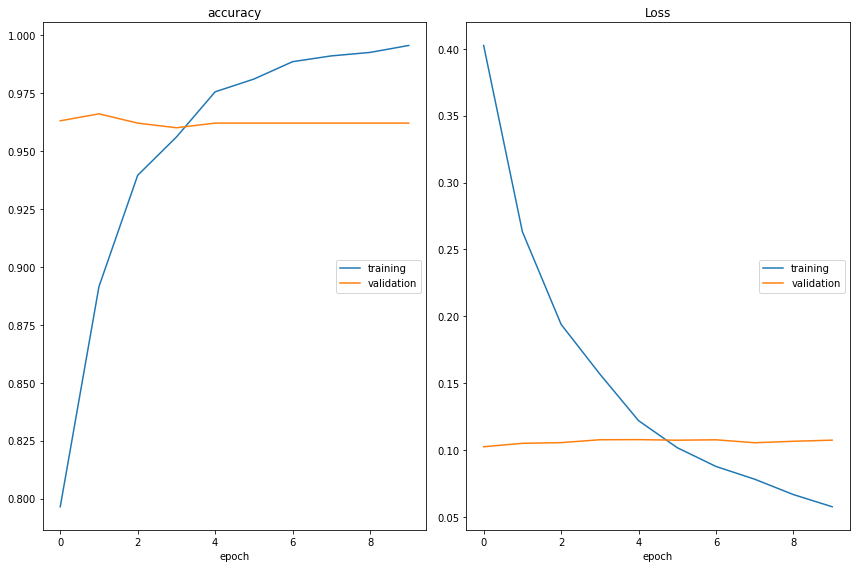

accuracy
	training         	 (min:    0.797, max:    0.996, cur:    0.996)
	validation       	 (min:    0.960, max:    0.966, cur:    0.962)
Loss
	training         	 (min:    0.058, max:    0.402, cur:    0.058)
	validation       	 (min:    0.102, max:    0.108, cur:    0.107)
20/20 [==============================] - 11s 566ms/step - loss: 0.0576 - accuracy: 0.9955 - val_loss: 0.1074 - val_accuracy: 0.9620


In [ ]:
EPOCHS = 10
history = model.fit_generator(
    train_data_gen,
    epochs=EPOCHS,
    validation_data=val_data_gen,
    callbacks=[PlotLossesCallback()])

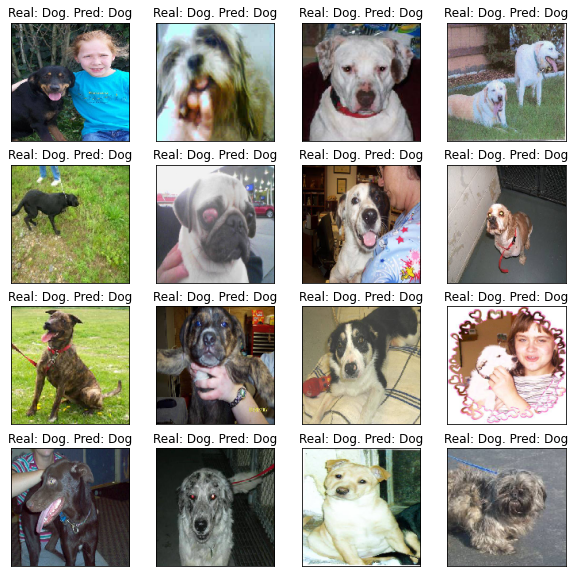

In [ ]:
sample_validation_images, sample_validation_labels = next(val_data_gen)
predicted = (model.predict(sample_validation_images) > 0.5).astype("int32").flatten()


show_catsdogs(sample_validation_images, sample_validation_labels, predicted)

# Заключение

В этом модуле вы познакомились со сверточными нейронными сетями и современными подходами к их обучению. В домашнем задании вы воспользуетесь всеми полученными знаниями для реализации классификатора пола и расы людей по фотографии! Удачи!